# Expedia Hotel Recommendations — Exploratory Data Analysis

**Dataset**: `expedia-hotel-recommendations/train.csv`  
**Rows**: ~37.6 million  |  **Columns**: 24  |  **Period**: 2013–2014  
**Objective**: Predict which hotel cluster a user will book.

1. [Load & Preview Data](#1)
2. [Shape, Data Types & Descriptive Statistics](#2)
3. [Missing Values Analysis](#3)
4. [Target Variable Distribution](#4)
5. [User Activity Analysis](#5)
6. [Temporal Analysis](#6)
7. [Geographic Analysis](#7)
8. [Booking vs Click Analysis](#8)
9. [Correlation Analysis](#9)
10. [Feature Distributions & Outlier Detection](#10)
11. [Key Insights & Recommendations](#11)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

---
## 1. Load & Preview the Dataset <a id='1'></a>

Read `train.csv` into a DataFrame using a 1M-row sample. The full file has ~37.6 M rows. A representative sample lets us explore the data quickly.

In [15]:
DATA_PATH   = 'expedia-hotel-recommendations/train.csv'
SAMPLE_SIZE = 1000000        # increase to use more data
TOTAL_ROWS  = 37670293       # total rows in train.csv (excluding header)
RANDOM_SEED = 42

print(f"Sampling {SAMPLE_SIZE:,} random rows from {TOTAL_ROWS:,} total …")

# Generate random row indices to SKIP (keeping header at row 0)
np.random.seed(RANDOM_SEED)
skip_rows = np.random.choice(
    np.arange(1, TOTAL_ROWS + 1),          # all row indices (1-based, header=0)
    size=TOTAL_ROWS - SAMPLE_SIZE,         # how many to skip
    replace=False
)

df = pd.read_csv(DATA_PATH, skiprows=skip_rows)


print(f"  Loaded  →  {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"  Memory  :  {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB\n")

# Column reference table
COL_INFO = {
    'date_time':                 'Timestamp of the search/booking event',
    'site_name':                 'Expedia website ID (e.g. .com, .co.uk)',
    'posa_continent':            'Continent of the point-of-sale',
    'user_location_country':     'User country code',
    'user_location_region':      'User region code',
    'user_location_city':        'User city code',
    'orig_destination_distance': 'Distance (km) between user and destination — has NaNs',
    'user_id':                   'Unique user identifier',
    'is_mobile':                 'Binary: 1=mobile, 0=desktop',
    'is_package':                'Binary: 1=flight+hotel package, 0=hotel only',
    'channel':                   'Booking channel ID',
    'srch_ci':                   'Check-in date',
    'srch_co':                   'Check-out date',
    'srch_adults_cnt':           'Number of adults in search',
    'srch_children_cnt':         'Number of children in search',
    'srch_rm_cnt':               'Number of rooms requested',
    'srch_destination_id':       'Destination ID',
    'srch_destination_type_id':  'Destination type (city, airport …)',
    'is_booking':                'Binary: 1=actual booking, 0=click only',
    'cnt':                       'Count of similar grouped events',
    'hotel_continent':           'Hotel continent code',
    'hotel_country':             'Hotel country code',
    'hotel_market':              'Hotel market ID',
    'hotel_cluster':             'TARGET — hotel cluster (0-99)',
}
print(pd.DataFrame.from_dict(COL_INFO, orient='index', columns=['Description']).to_string())
df.head()

Sampling 1,000,000 random rows from 37,670,293 total …
  Loaded  →  1,000,000 rows x 24 columns
  Memory  :  337.5 MB

                                                                     Description
date_time                                  Timestamp of the search/booking event
site_name                                 Expedia website ID (e.g. .com, .co.uk)
posa_continent                                    Continent of the point-of-sale
user_location_country                                          User country code
user_location_region                                            User region code
user_location_city                                                User city code
orig_destination_distance  Distance (km) between user and destination — has NaNs
user_id                                                   Unique user identifier
is_mobile                                            Binary: 1=mobile, 0=desktop
is_package                          Binary: 1=flight+hotel package, 0=h

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21
1,2014-11-23 17:10:17,30,4,195,991,47725,NaN,1048,0,0,...,0,1,8803,1,0,1,3,151,69,82
2,2014-09-15 19:07:14,2,3,66,311,45008,NaN,1561,0,0,...,0,1,52565,7,0,1,2,50,674,68
3,2013-12-02 02:05:21,24,2,3,64,12576,NaN,2451,0,0,...,0,1,18489,6,0,1,6,105,29,8
4,2014-07-18 02:09:17,24,2,3,64,12576,NaN,2451,0,0,...,0,1,17823,1,0,1,6,105,770,99


---
## 2. Shape, Data Types & Descriptive Statistics <a id='2'></a>

- Inspect column data types and overall structure to know which columns are numeric vs. object. 
- **Descriptive statistics:** quickly spot extreme min/max values (potential outliers), zero-variance columns, and the overall spread of each feature.

In [16]:
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
print("─── Data types ───────────────────────────────────")
print(df.dtypes)
print("\n─── General info ─────────────────────────────────")
df.info(memory_usage='deep')

df.describe(include='all').T

Shape: 1,000,000 rows × 24 columns

─── Data types ───────────────────────────────────
date_time                     object
site_name                      int64
posa_continent                 int64
user_location_country          int64
user_location_region           int64
user_location_city             int64
orig_destination_distance    float64
user_id                        int64
is_mobile                      int64
is_package                     int64
channel                        int64
srch_ci                       object
srch_co                       object
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
srch_destination_id            int64
srch_destination_type_id       int64
is_booking                     int64
cnt                            int64
hotel_continent                int64
hotel_country                  int64
hotel_market                   int64
hotel_cluster                  int64
dtype: object

─── Genera

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_time,1000000,988003,2014-07-24 14:34:52,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
site_name,1000000.0,NaN,NaN,NaN,9.824979,11.983646,2.0,2.0,2.0,15.0,53.0
posa_continent,1000000.0,NaN,NaN,NaN,2.678134,0.749749,0.0,3.0,3.0,3.0,4.0
user_location_country,1000000.0,NaN,NaN,NaN,86.079349,59.261237,0.0,66.0,66.0,70.0,239.0
user_location_region,1000000.0,NaN,NaN,NaN,308.124467,208.512816,0.0,174.0,314.0,385.0,1027.0
user_location_city,1000000.0,NaN,NaN,NaN,27727.636445,16783.717992,0.0,12907.0,27655.0,42328.0,56507.0
orig_destination_distance,639560.0,NaN,NaN,NaN,1970.378651,2235.684373,0.0056,311.5309,1138.1982,2552.529525,12050.7668
user_id,1000000.0,NaN,NaN,NaN,604545.793684,350575.37501,1.0,298524.5,604039.5,910727.25,1198780.0
is_mobile,1000000.0,NaN,NaN,NaN,0.134993,0.341716,0.0,0.0,0.0,0.0,1.0
is_package,1000000.0,NaN,NaN,NaN,0.24906,0.432469,0.0,0.0,0.0,0.0,1.0


---
## 3. Missing Values Analysis <a id='3'></a>

Count and visualise NaNs per column. Missing data can bias models. The `orig_destination_distance` column is ~37 % empty — we need a strategy: flag + median imputation, or model-based imputation before training.

Columns with missing values:
                           missing_count  missing_perc
orig_destination_distance         360440       36.0440
srch_ci                             1242        0.1242
srch_co                             1242        0.1242


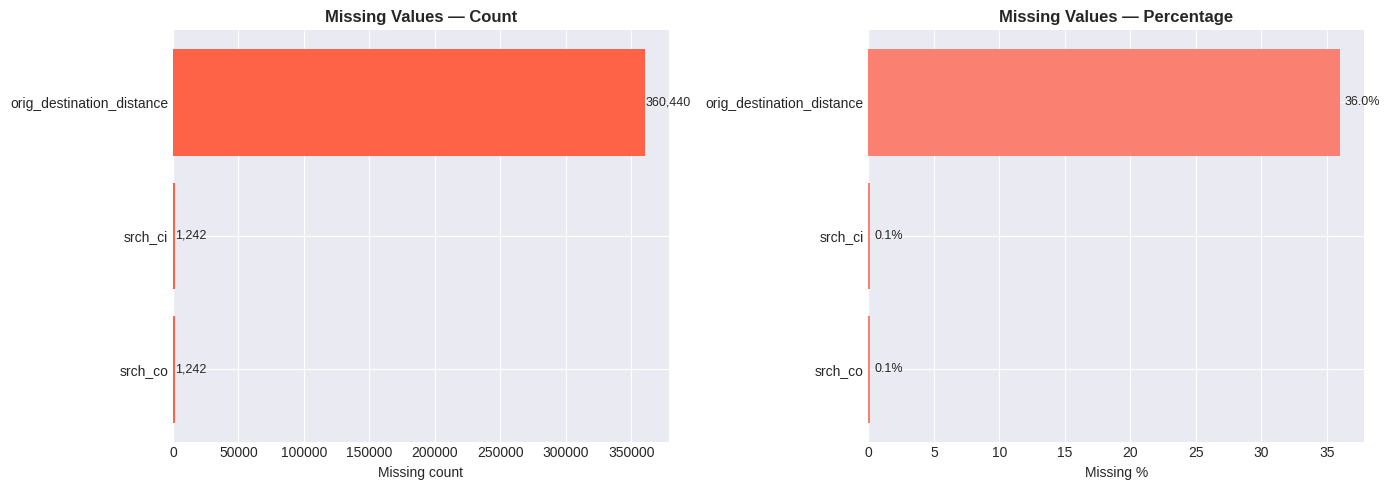

In [17]:

miss = pd.DataFrame({
    'missing_count':  df.isnull().sum(),
    'missing_perc':    df.isnull().mean() * 100,
}).sort_values('missing_perc', ascending=False)
miss = miss[miss['missing_count'] > 0]

print("Columns with missing values:")
print(miss.to_string())

if not miss.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left — absolute count
    axes[0].barh(miss.index, miss['missing_count'], color='tomato')
    axes[0].set_xlabel('Missing count')
    axes[0].set_title('Missing Values — Count', fontweight='bold')
    axes[0].invert_yaxis()
    for i, v in enumerate(miss['missing_count']):
        axes[0].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

    # Right — percentage
    axes[1].barh(miss.index, miss['missing_perc'], color='salmon')
    axes[1].set_xlabel('Missing %')
    axes[1].set_title('Missing Values — Percentage', fontweight='bold')
    axes[1].invert_yaxis()
    for i, v in enumerate(miss['missing_perc']):
        axes[1].text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("✓ No missing values!")

---
## 4. Target Variable Distribution <a id='4'></a>

Analyse the distribution of `hotel_cluster` (100-class target). Class imbalance directly affects model choice and evaluation. If some clusters dominate, a naive model could achieve high accuracy by ignoring rare classes.

Unique clusters  : 100
Range            : 0 - 99
Max/min ratio    : 20.6 x  ← class imbalance

Top 10 clusters:
hotel_cluster
91    27437
41    20810
48    20160
64    18688
65    17684
5     16487
98    15555
59    15103
21    14768
42    14663


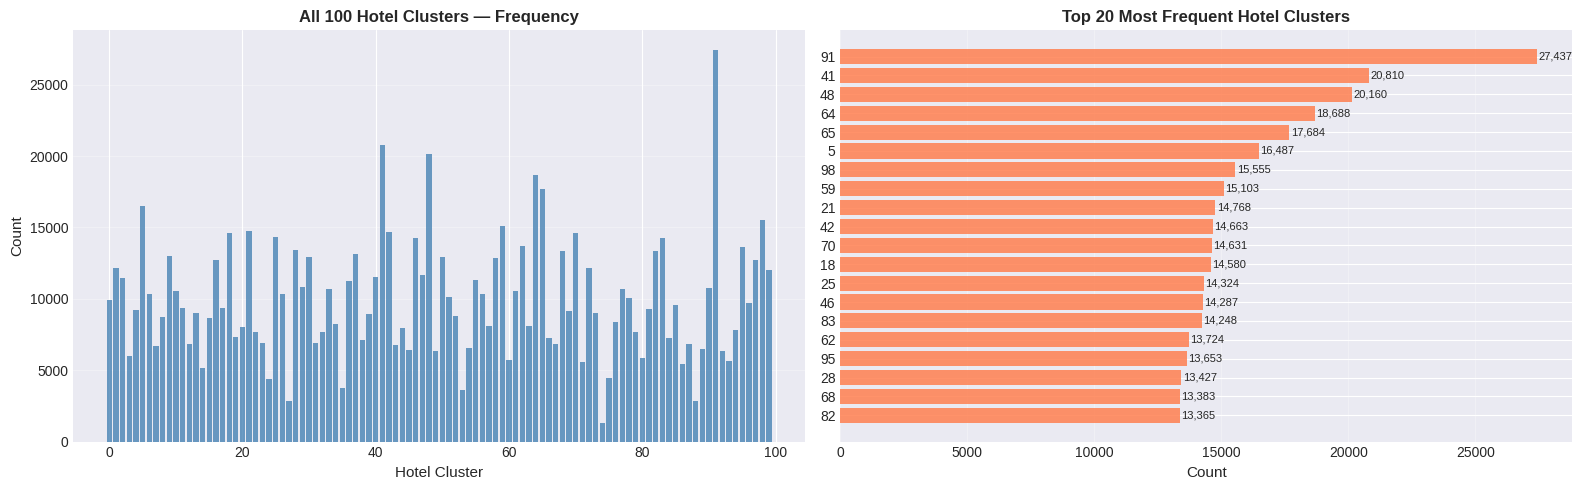

In [18]:
cluster_counts = df['hotel_cluster'].value_counts().sort_index()
imbalance      = cluster_counts.max() / cluster_counts.min()

print(f"Unique clusters  : {df['hotel_cluster'].nunique()}")
print(f"Range            : {df['hotel_cluster'].min()} - {df['hotel_cluster'].max()}")
print(f"Max/min ratio    : {imbalance:.1f} x  ← class imbalance")
print(f"\nTop 10 clusters:\n{df['hotel_cluster'].value_counts().head(10).to_string()}")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# All 100 clusters
axes[0].bar(cluster_counts.index, cluster_counts.values, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Hotel Cluster', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('All 100 Hotel Clusters — Frequency', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Top-20 clusters
top20 = df['hotel_cluster'].value_counts().head(20)
axes[1].barh(top20.index.astype(str), top20.values, color='coral', alpha=0.85)
axes[1].invert_yaxis()
axes[1].set_xlabel('Count', fontsize=11)
axes[1].set_title('Top 20 Most Frequent Hotel Clusters', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(top20.values):
    axes[1].text(v + 50, i, f'{v:,}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

---
## 5. User Activity Analysis <a id='5'></a>

Explore user-level behaviour — device type and package preference. Device and package flags are known to correlate with intent and willingness to pay.

Device Type:
  Desktop : 865,007 (86.5%)
  Mobile  : 134,993 (13.5%)

Booking Type:
  Hotel-only      : 750,940 (75.1%)
  Package deal    : 249,060 (24.9%)


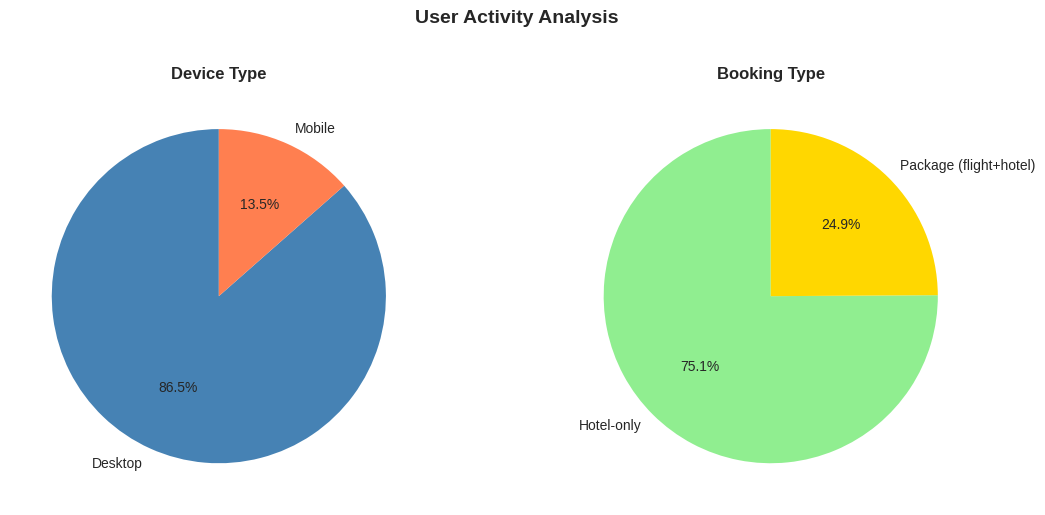

In [19]:
# Mobile vs Desktop
mob = df['is_mobile'].value_counts()
pkg = df['is_package'].value_counts()

print(f"Device Type:")
print(f"  Desktop : {mob.get(0, 0):,} ({mob.get(0,0)/len(df)*100:.1f}%)")
print(f"  Mobile  : {mob.get(1, 0):,} ({mob.get(1,0)/len(df)*100:.1f}%)")
print(f"\nBooking Type:")
print(f"  Hotel-only      : {pkg.get(0, 0):,} ({pkg.get(0,0)/len(df)*100:.1f}%)")
print(f"  Package deal    : {pkg.get(1, 0):,} ({pkg.get(1,0)/len(df)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1 — Mobile vs Desktop
axes[0].pie(mob.values, labels=['Desktop', 'Mobile'], autopct='%1.1f%%',
            colors=['steelblue', 'coral'], startangle=90)
axes[0].set_title('Device Type', fontweight='bold')

# 2 — Package vs Hotel-only
axes[1].pie(pkg.values, labels=['Hotel-only', 'Package (flight+hotel)'],
            autopct='%1.1f%%', colors=['lightgreen', 'gold'], startangle=90)
axes[1].set_title('Booking Type', fontweight='bold')

plt.suptitle('User Activity Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Temporal Analysis <a id='6'></a>

Parse date columns, extract calendar components, compute stay duration and booking lead time. Seasonality, weekday and weekend effects, and advance-booking windows are strong signals for which hotel cluster a user will choose.

*Median Lead Time business interpretation for an OTA*
- Short lead time (0–3 days) → last-minute traveller, likely less price-sensitive
- Medium lead time (7–30 days) → planned leisure trip
- Long lead time (60+ days) → vacation packages, international travel

Date range : 2013-01-07 00:02:36 to 2014-12-31 23:56:46
Median stay duration : 3 nights
Median lead time (days between searches and check-in date): 29 days


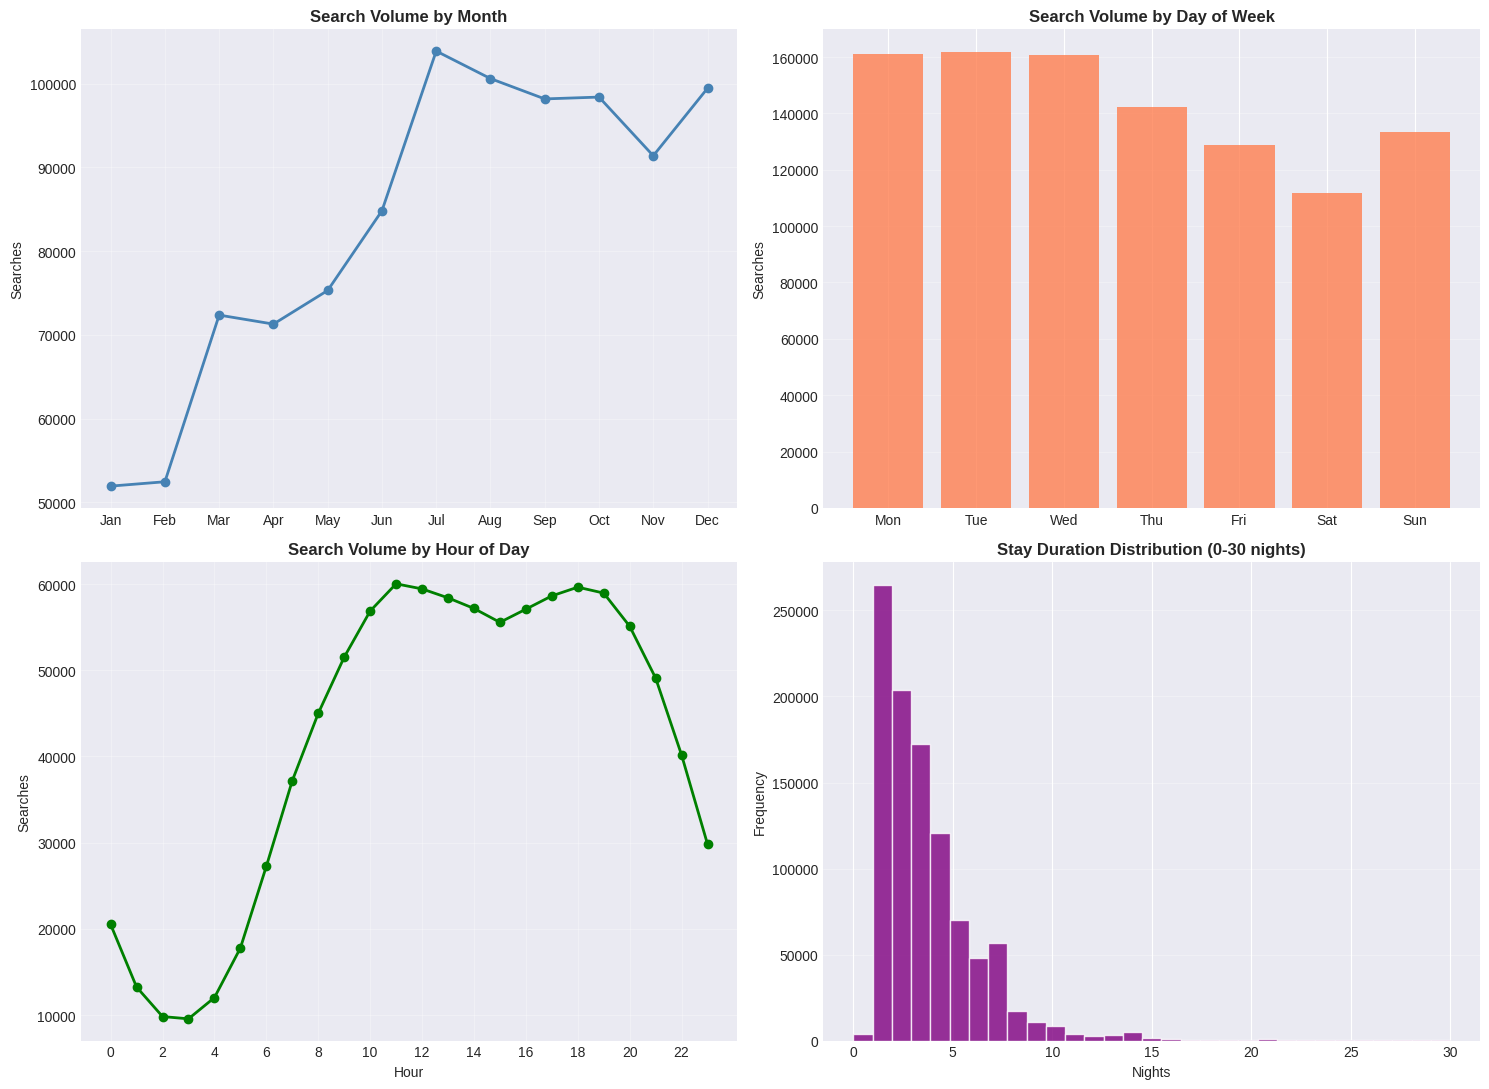

In [22]:
# Parse dates (converting a raw text string into a proper datetime object to allow operate mathematically)
df['date_time'] = pd.to_datetime(df['date_time'])
df['srch_ci']   = pd.to_datetime(df['srch_ci'],  errors='coerce')
df['srch_co']   = pd.to_datetime(df['srch_co'],  errors='coerce')

# Definiton of Temporal features
df['search_year']     = df['date_time'].dt.year
df['search_month']    = df['date_time'].dt.month
df['search_weekday']  = df['date_time'].dt.dayofweek   # 0=Mon
df['search_hour']     = df['date_time'].dt.hour
df['stay_duration']   = (df['srch_co'] - df['srch_ci']).dt.days
df['lead_time']       = (df['srch_ci'] - df['date_time']).dt.days

MONTH_LABELS   = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
WEEKDAY_LABELS = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

print("Date range :", df['date_time'].min(), "to", df['date_time'].max())
print(f"Median stay duration : {df['stay_duration'].median():.0f} nights")
print(f"Median lead time (days between searches and check-in date): {df['lead_time'].median():.0f} days")

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# 1. Monthly search volume
month_cnt = df['search_month'].value_counts().sort_index()
axes[0, 0].plot(month_cnt.index, month_cnt.values, marker='o', linewidth=2, color='steelblue')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(MONTH_LABELS)
axes[0, 0].set_title('Search Volume by Month', fontweight='bold')
axes[0, 0].set_ylabel('Searches')
axes[0, 0].grid(True, alpha=0.3)

# 2. Weekday search volume
wd_cnt = df['search_weekday'].value_counts().sort_index()
axes[0, 1].bar(WEEKDAY_LABELS, [wd_cnt.get(i, 0) for i in range(7)], color='coral', alpha=0.8)
axes[0, 1].set_title('Search Volume by Day of Week', fontweight='bold')
axes[0, 1].set_ylabel('Searches')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Hourly search volume
hr_cnt = df['search_hour'].value_counts().sort_index()
axes[1, 0].plot(hr_cnt.index, hr_cnt.values, marker='o', linewidth=2, color='green')
axes[1, 0].set_title('Search Volume by Hour of Day', fontweight='bold')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Searches')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].grid(True, alpha=0.3)

# 4. Stay duration distribution
stay_filt = df['stay_duration'].clip(0, 30).dropna()
axes[1, 1].hist(stay_filt, bins=31, color='purple', alpha=0.8, edgecolor='white')
axes[1, 1].set_title('Stay Duration Distribution (0-30 nights)', fontweight='bold')
axes[1, 1].set_xlabel('Nights')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Geographic Analysis <a id='7'></a>

Explore the geographic spread of users and hotel locations. A user searching from the same continent as the hotel likely behaves differently from a long-haul traveller. Geographic features often rank among the top predictors.

Geographic cardinality
  posa_continent          : 5 unique values
  user_location_country   : 227 unique values
  user_location_region    : 922 unique values
  user_location_city      : 26,202 unique values
  hotel_continent         : 7 unique values
  hotel_country           : 201 unique values
  hotel_market            : 2,093 unique values
  srch_destination_id     : 23,305 unique values

Same continent (user ↔ hotel): 6.4% of searches


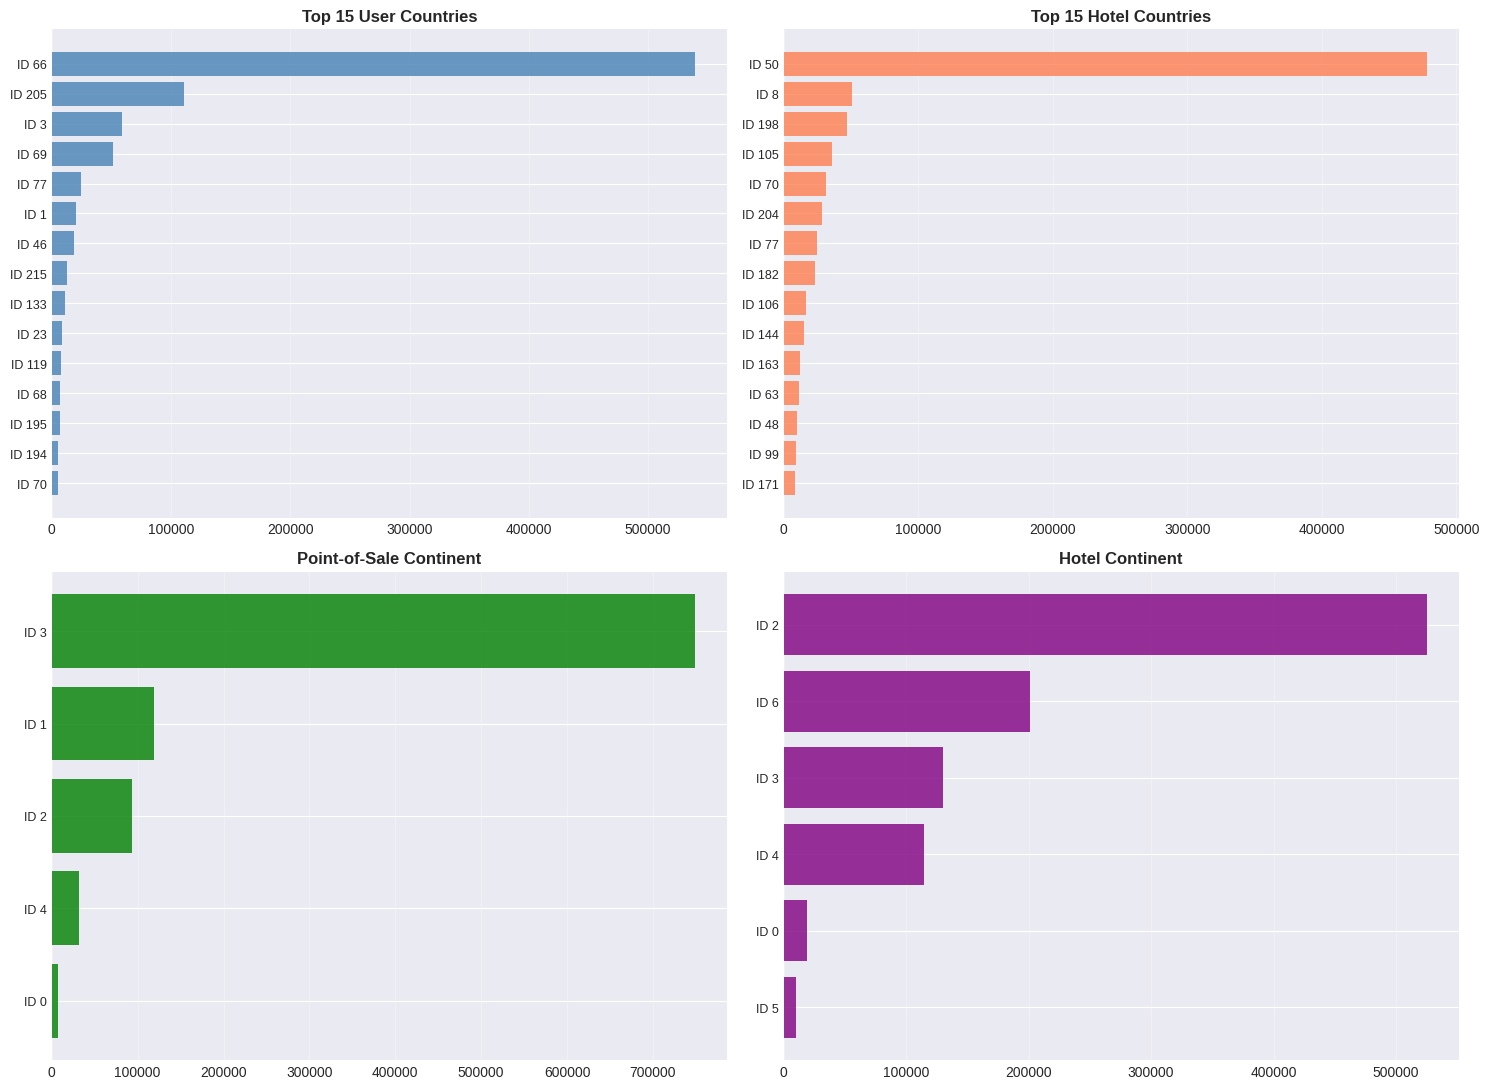

In [24]:
print("Geographic cardinality")
print(f"  posa_continent          : {df['posa_continent'].nunique()} unique values")
print(f"  user_location_country   : {df['user_location_country'].nunique():,} unique values")
print(f"  user_location_region    : {df['user_location_region'].nunique():,} unique values")
print(f"  user_location_city      : {df['user_location_city'].nunique():,} unique values")
print(f"  hotel_continent         : {df['hotel_continent'].nunique()} unique values")
print(f"  hotel_country           : {df['hotel_country'].nunique():,} unique values")
print(f"  hotel_market            : {df['hotel_market'].nunique():,} unique values")
print(f"  srch_destination_id     : {df['srch_destination_id'].nunique():,} unique values")

df['same_continent'] = (df['posa_continent'] == df['hotel_continent']).astype(int)
print(f"\nSame continent (user ↔ hotel): {df['same_continent'].mean()*100:.1f}% of searches")

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

def hbar(ax, series, n, color, title):
    top = series.value_counts().head(n)
    ax.barh(range(len(top)), top.values, color=color, alpha=0.8)
    ax.set_yticks(range(len(top)))
    ax.set_yticklabels([f'ID {v}' for v in top.index], fontsize=9)
    ax.invert_yaxis()
    ax.set_title(title, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

hbar(axes[0, 0], df['user_location_country'], 15, 'steelblue', 'Top 15 User Countries')
hbar(axes[0, 1], df['hotel_country'],         15, 'coral',     'Top 15 Hotel Countries')
hbar(axes[1, 0], df['posa_continent'],         6, 'green',     'Point-of-Sale Continent')
hbar(axes[1, 1], df['hotel_continent'],        6, 'purple',    'Hotel Continent')

plt.tight_layout()
plt.show()



---
## 8. Booking vs Click Analysis <a id='8'></a>

Compare conversion rates (actual bookings) vs. clicks across devices, packages, channels, and time. Clicks reflect intent but not commitment. Understanding what converts helps prioritise features and validate the model's focus on booking events.

Overall conversion rate  : 7.98%
Total bookings           : 79,830
Total clicks (no book)   : 920,170


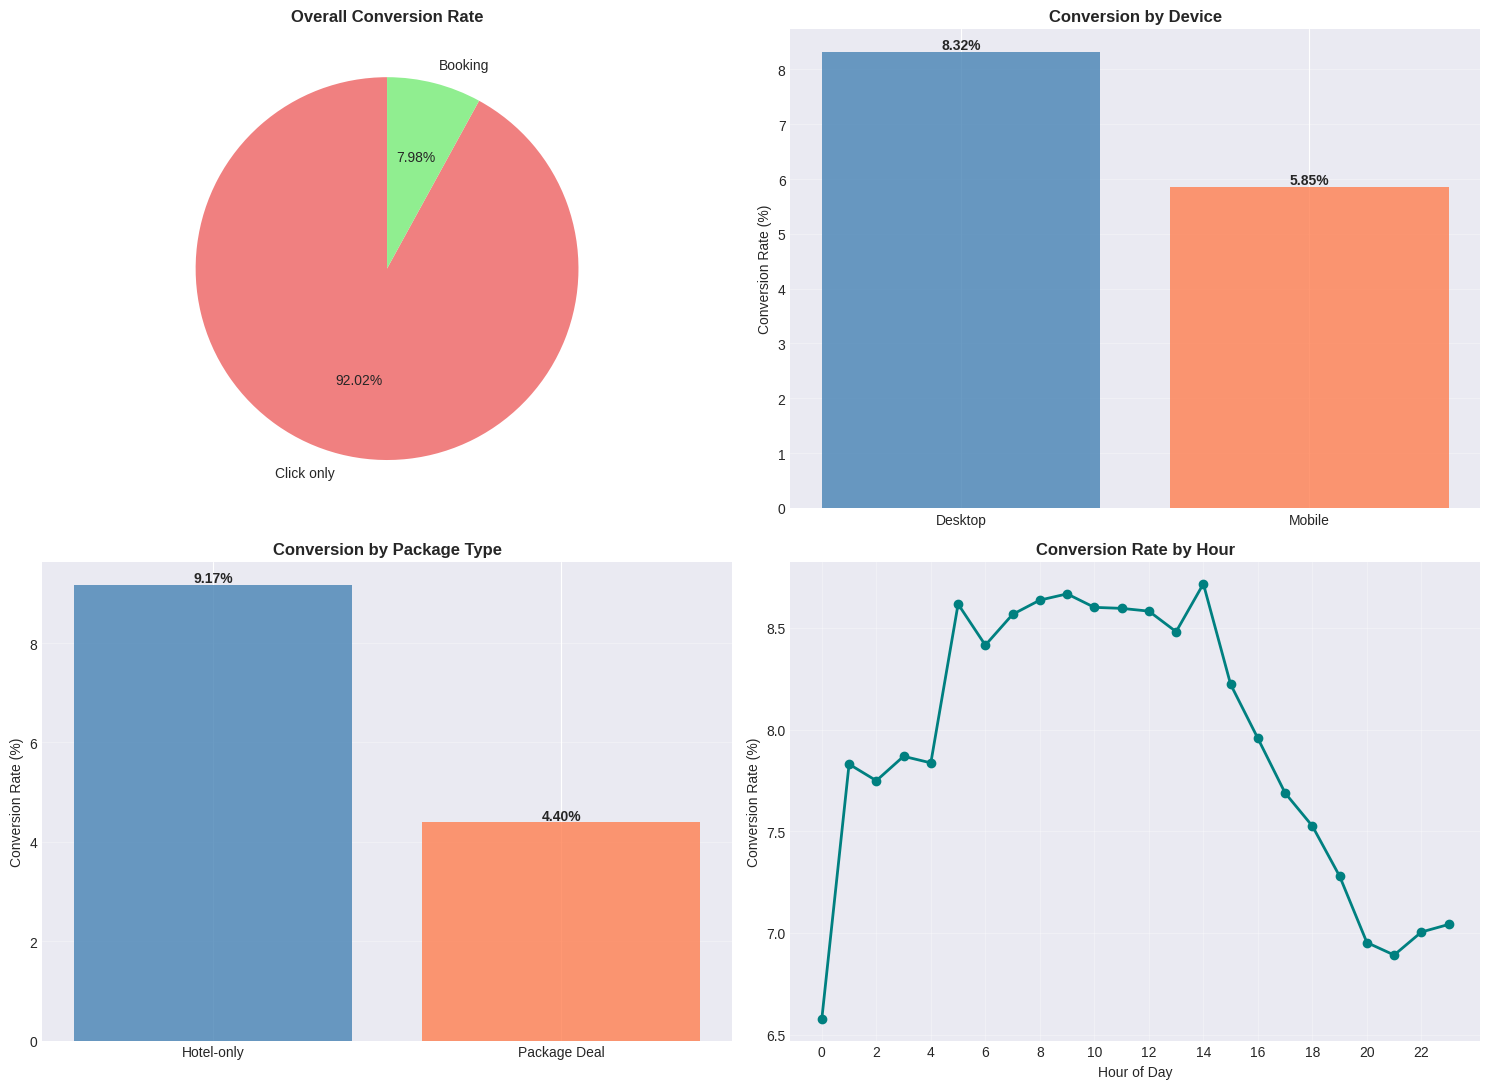

In [25]:
booking_rate = df['is_booking'].mean() * 100
print(f"Overall conversion rate  : {booking_rate:.2f}%")
print(f"Total bookings           : {df['is_booking'].sum():,}")
print(f"Total clicks (no book)   : {(df['is_booking']==0).sum():,}")

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# 1 — Overall convertion rate
bc = df['is_booking'].value_counts()
axes[0, 0].pie(bc.values, labels=['Click only', 'Booking'],
               autopct='%1.2f%%', colors=['lightcoral', 'lightgreen'], startangle=90)
axes[0, 0].set_title('Overall Conversion Rate', fontweight='bold')

def conv_bar(ax, col, labels, title):
    rates = df.groupby(col)['is_booking'].mean() * 100
    bars  = ax.bar(labels[:len(rates)], rates.values, color=['steelblue', 'coral', 'green', 'purple'][:len(rates)], alpha=0.8)
    ax.set_ylabel('Conversion Rate (%)')
    ax.set_title(title, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{bar.get_height():.2f}%', ha='center', fontsize=10, fontweight='bold')

# 2 — By device
conv_bar(axes[0, 1], 'is_mobile', ['Desktop', 'Mobile'], 'Conversion by Device')

# 3 — By package type
conv_bar(axes[1, 0], 'is_package', ['Hotel-only', 'Package Deal'], 'Conversion by Package Type')

# 4 — By hour
hr_conv = df.groupby('search_hour')['is_booking'].mean() * 100
axes[1, 1].plot(hr_conv.index, hr_conv.values, marker='o', linewidth=2, color='teal')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Conversion Rate (%)')
axes[1, 1].set_title('Conversion Rate by Hour', fontweight='bold')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9. Correlation Analysis <a id='9'></a>

Compute the Pearson correlation matrix for all numeric features. Strongly correlated features add redundancy and can hurt certain models. Weak correlations with the target signal that non-linear approaches (tree ensembles, neural nets) are needed.

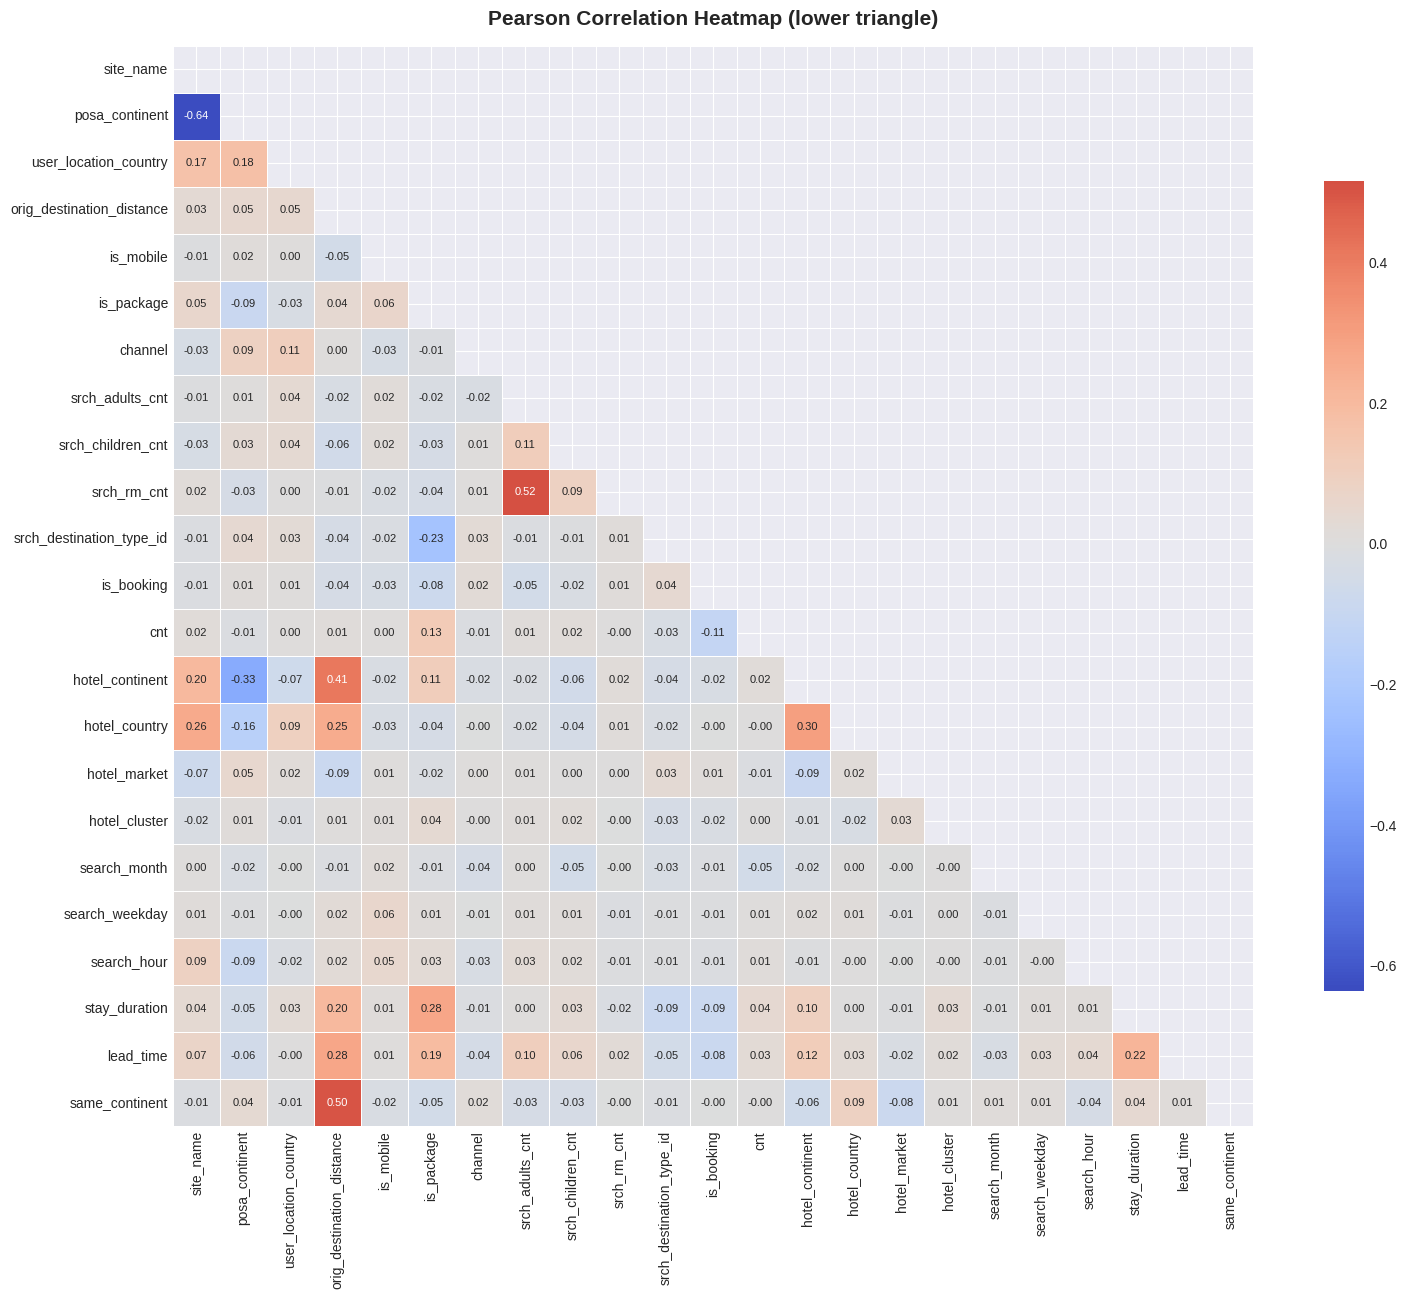

Top 15 features correlated with hotel_cluster:
is_package                   0.038535
stay_duration                0.034616
hotel_market                 0.033487
srch_destination_type_id     0.032855
hotel_country                0.024930
site_name                    0.021536
lead_time                    0.021018
is_booking                   0.020366
srch_children_cnt            0.018238
hotel_continent              0.014892
posa_continent               0.014424
srch_adults_cnt              0.013557
user_location_country        0.010869
is_mobile                    0.008354
orig_destination_distance    0.006294


In [27]:
# Drop high-cardinality ID columns before correlation
drop_for_corr = ['user_id', 'srch_destination_id', 'user_location_city',
                 'user_location_region', 'search_year']

# Keep only numeric columns
num_df = df.select_dtypes(include=np.number).drop(columns=drop_for_corr, errors='ignore')

# Pearson correlation matrix
corr = num_df.corr()

plt.figure(figsize=(16, 13))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.75}, annot_kws={'size': 8})
plt.title('Pearson Correlation Heatmap (lower triangle)', fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Top features correlated with hotel_cluster (target)
tgt_corr = corr['hotel_cluster'].drop('hotel_cluster').abs().sort_values(ascending=False)
print("Top 15 features correlated with hotel_cluster:")
print(tgt_corr.head(15).to_string())

### Some conclusions

**1. Zero Linear Predictive Power**
The highest correlation is only 0.039 (is_package). In statistics:

- r < 0.10 = negligible linear relationship
- r < 0.30 = weak
- r > 0.50 = moderate

This does NOT mean the features are useless — it means the relationship between features and hotel_cluster is purely non-linear.

#### These will NOT work for this problem:
- X: Logistic Regression
- X: Linear SVM
- X: Ridge/Lasso Classifier

#### These WILL work:
- OK: LightGBM       → best choice (fast, handles categoricals)
- OK: XGBoost        → strong alternative
- OK: CatBoost       → best for high-cardinality categoricals
- OK: Random Forest  → good baseline

---
## 10. Feature Distributions & Outlier Detection <a id='10'></a>

Histograms and boxplots for key numeric features. Outliers can dominate loss functions and distort model learning. Skewed distributions may benefit from log-transformation before training.

srch_adults_cnt                      99th pct=      6.00  |  outlier rows=0.40%
srch_children_cnt                    99th pct=      3.00  |  outlier rows=0.47%
srch_rm_cnt                          99th pct=      3.00  |  outlier rows=0.59%
orig_destination_distance            99th pct=   9643.07  |  outlier rows=1.00%
stay_duration                        99th pct=     14.00  |  outlier rows=0.67%
lead_time                            99th pct=    299.00  |  outlier rows=0.99%
cnt                                  99th pct=      6.00  |  outlier rows=0.99%


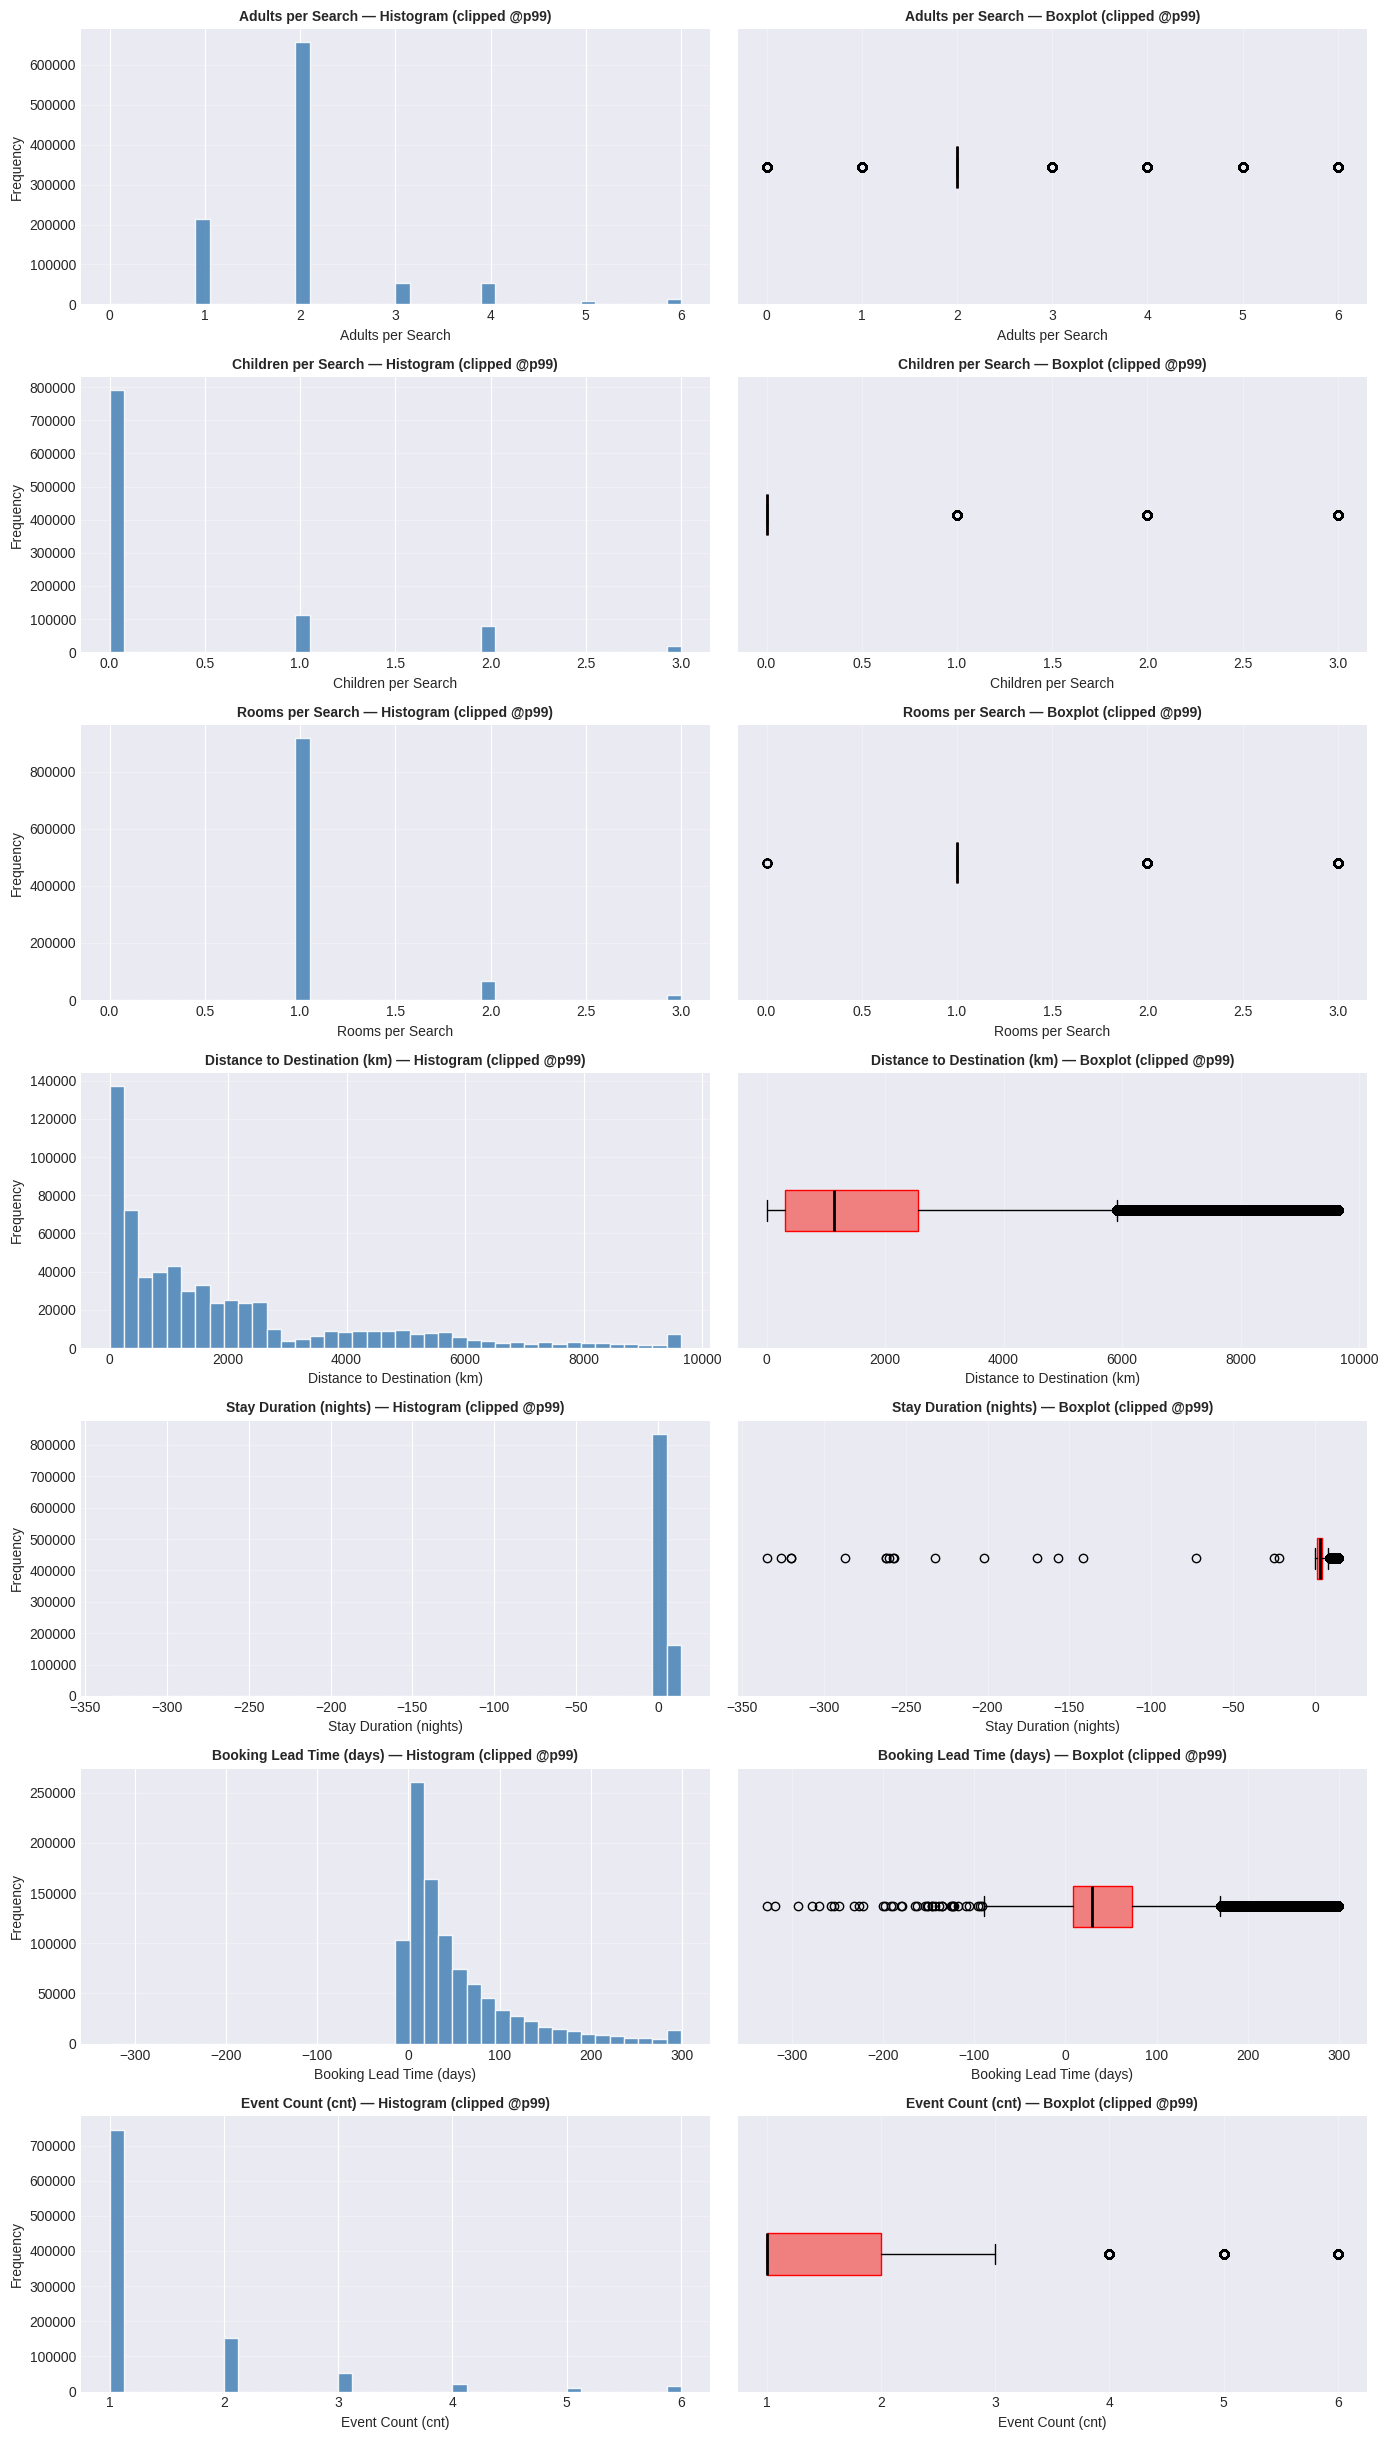

In [28]:
features = {
    'srch_adults_cnt':           'Adults per Search',
    'srch_children_cnt':         'Children per Search',
    'srch_rm_cnt':               'Rooms per Search',
    'orig_destination_distance': 'Distance to Destination (km)',
    'stay_duration':             'Stay Duration (nights)',
    'lead_time':                 'Booking Lead Time (days)',
    'cnt':                       'Event Count (cnt)',
}

n = len(features)
fig, axes = plt.subplots(n, 2, figsize=(14, n * 3.5))

for i, (col, label) in enumerate(features.items()):
    data = df[col].dropna()

    # clip extreme outliers for readability
    p99  = data.quantile(0.99)
    data_cl = data.clip(upper=p99)

    # histogram
    axes[i, 0].hist(data_cl, bins=40, color='steelblue', edgecolor='white', alpha=0.85)
    axes[i, 0].set_title(f'{label} — Histogram (clipped @p99)', fontweight='bold', fontsize=10)
    axes[i, 0].set_xlabel(label)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(axis='y', alpha=0.3)

    # boxplot
    axes[i, 1].boxplot(data_cl, vert=False, patch_artist=True,
                       boxprops=dict(facecolor='lightcoral', color='red'),
                       medianprops=dict(color='black', linewidth=2))
    axes[i, 1].set_title(f'{label} — Boxplot (clipped @p99)', fontweight='bold', fontsize=10)
    axes[i, 1].set_xlabel(label)
    axes[i, 1].set_yticks([])
    axes[i, 1].grid(axis='x', alpha=0.3)

    # print outlier info
    out_pct = (data > p99).mean() * 100
    print(f"{col:35s}  99th pct={p99:>10.2f}  |  outlier rows={out_pct:.2f}%")

plt.tight_layout()
plt.show()

---
## 11. Key Insights & Recommendations <a id='11'></a>

### **Key Insights & Recommendations**

Target: **hotel_cluster:** 

100 classes (0 - 99) with moderate imbalance. 

**Evaluation metric:**  ***MAP@5***
- MAP@5 measures how well your model ranks the top 5 predicted hotel clusters against the actual booked cluster.

**Baseline** 
- Predict most-popular cluster per destination/country pair.

**Missing Data**
- orig_destination_distance ≈ ........ % NaN. Strategy: add binary flag distance_known + impute median per destination.

**Temporal - Seasonality**
- Clear seasonality — engineer month, week-of-year, is_weekend.
- Lead time and stay duration are strong booking-intent signals.
- Peak search hour varies — include hour_of_day as a feature.

**User Behaviour**
- Package deals and mobile sessions show distinct conversion patterns.

***Geographic**
- High cardinality (country, city) — target-encode or embed rather than one-hot.
- same_continent flag (user ↔ hotel) is a cheap but useful feature.
    
**Correlations**
- Weak linear correlations with hotel_cluster → non-linear models required.",
- Recommended: ***LightGBM / XGBoost / CatBoost ensemble***.

**Outliers**
- distance, lead_time, cnt all have heavy right tails.
- Apply log1p transform or clip at 99th percentile before training.",


#### ***Next Steps***
1. Feature engineering pipeline (temporal + geographic + user aggregates).
2. Merge destinations.csv for latent destination embeddings.
3. Train LightGBM baseline → evaluate MAP@5 on validation fold.
4. Hyperparameter tuning + model stacking: also called Stacked Generalization, is an ensemble technique that combines multiple different models to produce a stronger final prediction.
